In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.16.0 / PyTorch 2.6.0+cu124


In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [ ]:
from flwr_datasets.partitioner import DirichletPartitioner

# alpha=10 (iid), alpha=(0,1/0.3) noniid; alpha=0.01 (extreme noniid)
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.3,partition_by="label",seed=42)

In [ ]:
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [ ]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

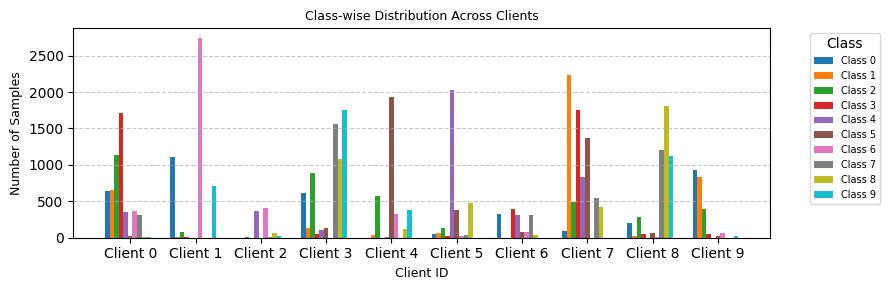

In [ ]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(net, trainloader):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    correct, total, train_loss = 0, 0, 0.0
    for batch in trainloader:
      images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
      optimizer.zero_grad() # Clear the gradients of all optimized tensors
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step() # Update model parameters

      train_loss += loss.item()
      total += labels.size(0)
      correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    train_loss /= len(trainloader.dataset)
    train_acc = correct / total
    return train_loss, train_acc

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    # disable gradient computation during evaluation
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(20):
    train_loss, train_acc = train(net, trainloader)
    val_loss, val_acc = test(net, valloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

Epoch 1: Train Loss 0.0552, Train Acc 0.3532 | Val Loss 0.0472, Val Acc 0.4578
Epoch 2: Train Loss 0.0452, Train Acc 0.4823 | Val Loss 0.0422, Val Acc 0.4885
Epoch 3: Train Loss 0.0409, Train Acc 0.5361 | Val Loss 0.0385, Val Acc 0.5613
Epoch 4: Train Loss 0.0390, Train Acc 0.5507 | Val Loss 0.0373, Val Acc 0.5859
Epoch 5: Train Loss 0.0373, Train Acc 0.5767 | Val Loss 0.0377, Val Acc 0.5744
Epoch 6: Train Loss 0.0359, Train Acc 0.5858 | Val Loss 0.0353, Val Acc 0.6143
Epoch 7: Train Loss 0.0345, Train Acc 0.6092 | Val Loss 0.0360, Val Acc 0.5966
Epoch 8: Train Loss 0.0331, Train Acc 0.6238 | Val Loss 0.0352, Val Acc 0.6035
Epoch 9: Train Loss 0.0320, Train Acc 0.6383 | Val Loss 0.0370, Val Acc 0.5920
Epoch 10: Train Loss 0.0311, Train Acc 0.6447 | Val Loss 0.0341, Val Acc 0.6166
Epoch 11: Train Loss 0.0295, Train Acc 0.6654 | Val Loss 0.0337, Val Acc 0.6319
Epoch 12: Train Loss 0.0282, Train Acc 0.6790 | Val Loss 0.0338, Val Acc 0.6403
Epoch 13: Train Loss 0.0269, Train Acc 0.6915 | V

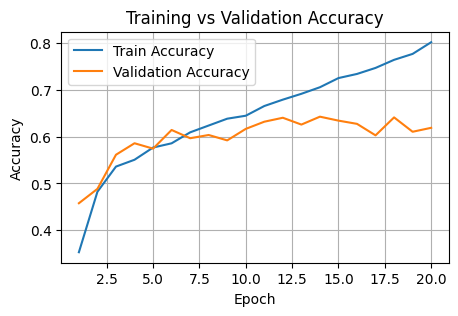

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\nloss {loss}\naccuracy {accuracy}")

Final test set performance:
loss 0.12837875771522522
accuracy 0.3973


**Federated learning with Flower**

---



In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
strategy = FedAvg(
    fraction_fit=1.0,  # 100% of available clients for training
    fraction_evaluate=0.5,  # 50% of available clients for evaluation
    min_fit_clients=10,  # Never less than 10 clients for training
    min_evaluate_clients=5,  # Never less than 5 clients for evaluation
    min_available_clients=10,  # Wait until 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=5591) 2025-03-24 05:31:52.315715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5591) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=5591) E0000 00:00:1742794312.359909    5591 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5591) E0000 00:00:1742794312.378391    5591 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=5594) /usr/local/lib/python3.11/dist-packages/jupyter_client/con

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)
server = ServerApp(server_fn=server_fn)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
(pid=8125) 2025-03-24 05:38:26.843110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8125) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=8125) E0000 00:00:1742794706.888194    8125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8125) E0000 00:00:1742794706.900520    8125 cuda_blas.cc:1418] Unable to register cuBLAS factory: Att

In [ ]:
from flwr.server.strategy import FedAdagrad
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
(pid=9406) 2025-03-24 05:41:28.916482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9406) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=9406) E0000 00:00:1742794888.994828    9406 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9406) E0000 00:00:1742794889.023242    9406 cuda_blas.cc:1418] Unable to register cuBLAS factory: Att